# Preprocessing code

### Necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz
from glob import glob

### Useful functions

In [2]:
# dataframe 속에 시간 항목을 datetime 데이터형으로 바꿔서 저장하는 함수
# boolean이 True인 경우 NaN 항목을 데이터프레임에서 삭제
# Set local timezone
seoultz = pytz.timezone('Asia/Seoul')


# 각 포스트 당 테그 수를 합산하여 테그수 열을 추가하는 함수
def num_tags(df_name):
    count = 0
    df_name['number of tags'] = np.zeros_like(df_name['uid'])
    
    for i, dtitem in enumerate(df_name['tags']):
        try:
            df_name['number of tags'][i] = dtitem.count('#')
        except:
            if str(dtitem).lower() == 'nan':
                df_name['number of tags'][i] = 0
            else:
                count += 1
    
    if count:
        print('Number of fails: %s'%count)
    else:
        print('success')

# tags 중 tag_name 언급 횟수를 기록하여 col_name 열을 추가하는 함수
def suyo_tags(df_name, tag_name, col_name):
    count = 0
    df_name[col_name] = np.zeros_like(df_name['uid'])
    
    for i, dtitem in enumerate(df_name['tags']):
        try:
            df_name[col_name][i] = dtitem.count(tag_name)
        except:
            if str(dtitem).lower() == 'nan':
                df_name[col_name][i] = 0
            else:
                count += 1
    
    if count:
        print("Number of fails: %s"%count)
        
# str 속성을 가진 정수를 int 속성으로 바꾸는 함수
def int_maker(df_name, col_name):
    count = 0
    
    for i, dtitem in enumerate(df_name[col_name]):
        try:
            df_name[col_name][i] = int(dtitem.replace(',', ''))
        except:
            if str(dtitem).lower() == 'nan':
                df_name[col_name][i] = int(0)
            else:
                count += 1
    
    if count:
        print("Number of fails: %s"%count)
        
# 같은 열 데이터 중 다른 데이터형이 있는지 확인하는 함수
def type_tester(df_name, col_name, tp):
    count = 0
    
    for dtitem in df_name[col_name]:
        if type(dtitem) != tp:
            count += 1
    
    if count:
        print("Number of different types: %s"%count)        

# 테그 : 빈도수 사전 리턴
def tag_analyze(df_name):
    test_list = []
    for item in df_name['tags']:
        if type(item) == str:
            test_list.append(item)
            #print(item)

    vect = CountVectorizer()
    vect.fit(test_list)
    voc_dic = vect.vocabulary_.items()
    voc_len = len(vect.transform(test_list).toarray()[0])
    number = np.zeros(voc_len)

    for np_item in vect.transform(test_list).toarray():
        number += np_item

    new_dic = {}
    for key, val in voc_dic:
        new_dic[key] = number[val]
    return new_dic

# 데이터프레임에 테그 리스트 열 추가
def add_tag_list(df_name):
    df_name['tag list'] = np.zeros_like(df_name['uid'])
    for i, t_item in enumerate(df_name['tags']):
        try:
            df_name['tag list'][i] = t_item.split('#')[1:]
            #print(t_item.split('#')[1:])
        except:
            df_name['tag list'][i] = []

# user id eraser
def eraser(t):
    usrlist = {}
    i = 0
    for item in t.split('>'):
        if ('<' in item) & (item.split('<')[-1] not in usrlist.keys()):
            i += 1
            usrlist[item.split('<')[1]] = 'user%s'%i
    for key, value in usrlist.iteritems():
        t = t.replace(key, value)
    return t

### Importing crawling file

In [42]:
data_dic = {}
for p in glob('%s/*.csv'%path):
    dt = pd.read_csv('%s'%p)
    dt = dt.drop(['uid', 'account'], axis=1) # Drop unnecessary column
    data_dic[p.split('_')[1].split('.')[0]] = dt

### Replace user id to arbitrary in comment

In [43]:
for res in data_dic.keys():
    for i in range(len(data_dic[res].comments)):
        try:
            data_dic[res].comments[i] = eraser(data_dic[res].comments[i])
        except:
            pass

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Missing values

shindle


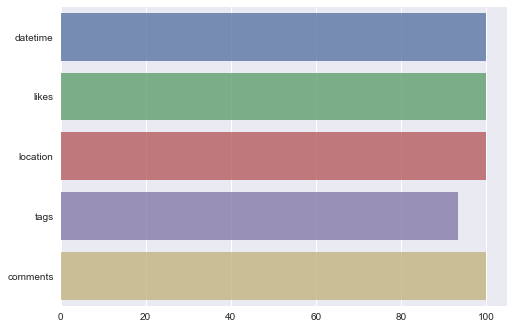

soiyn


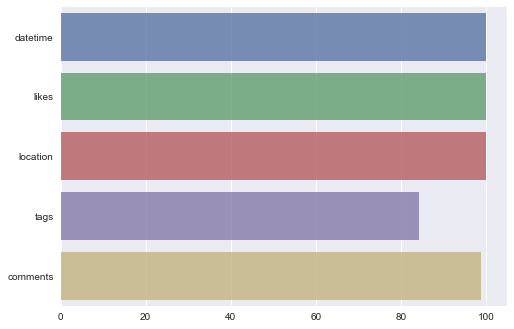

gunjane


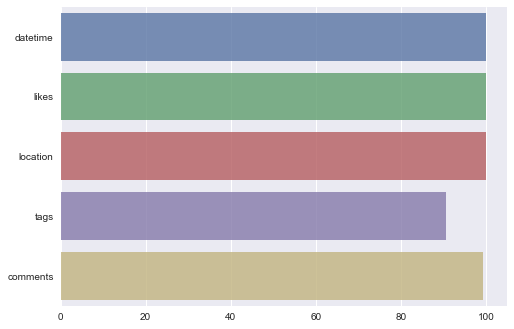

lehoi


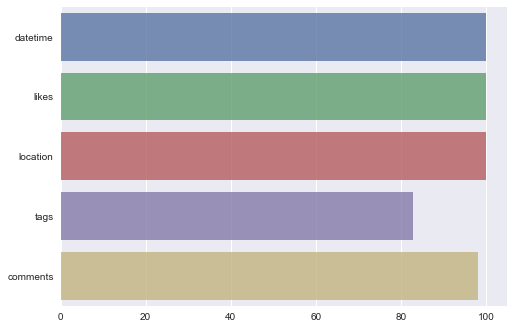

modak


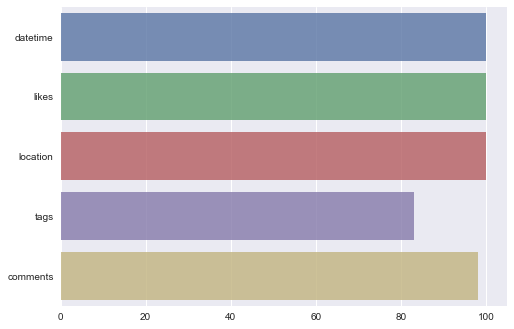

ongdalsem


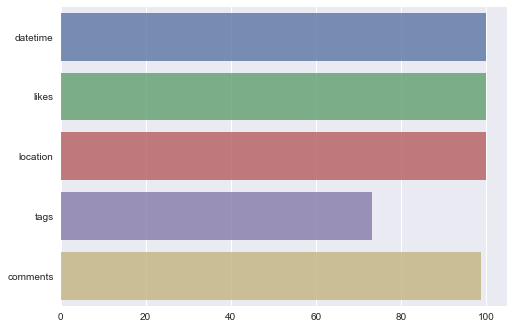

nali


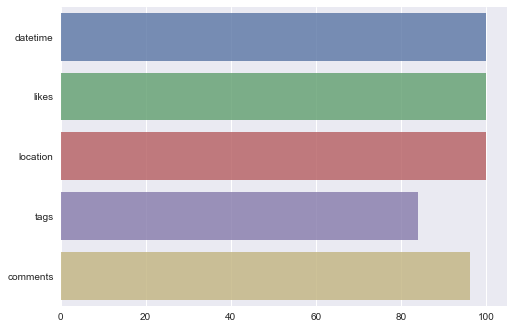

sushi


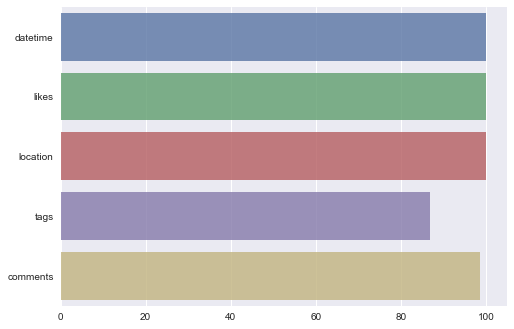

csdinoa


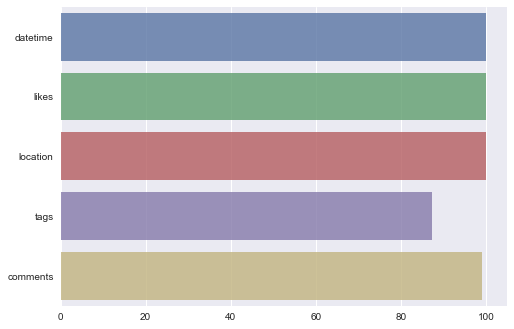

mapo


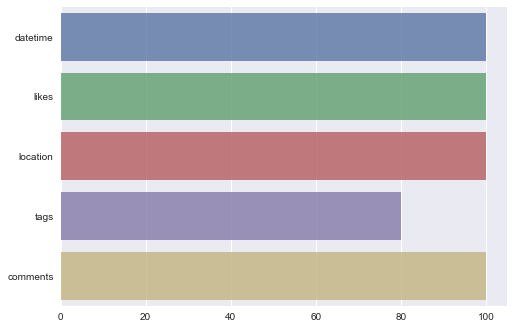

pildong


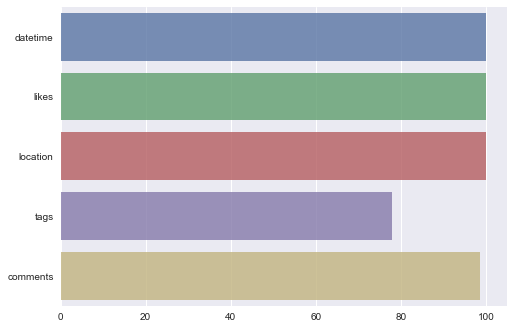

gpaki


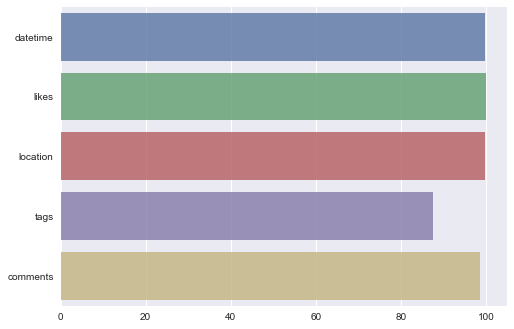

jinjin


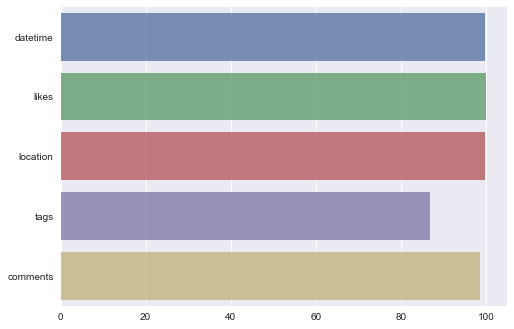

iamburger


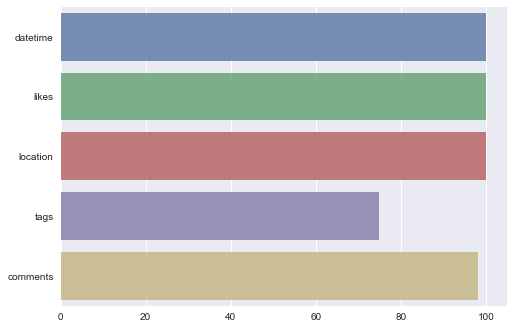

uijeongbu


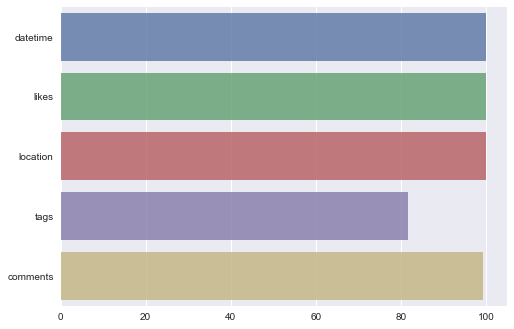

downtwnr


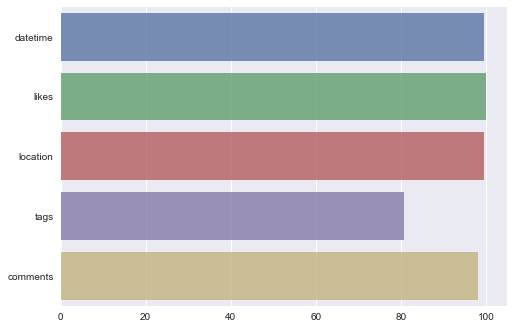

jinospizza


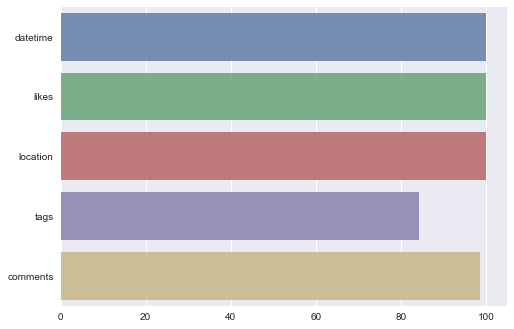

monro


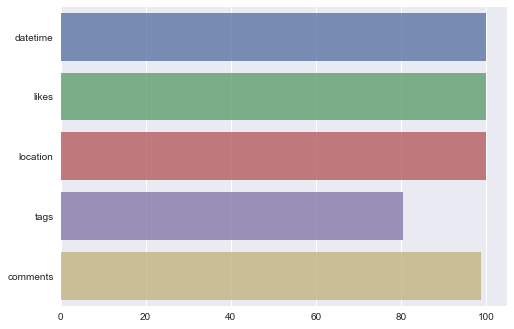

ichie


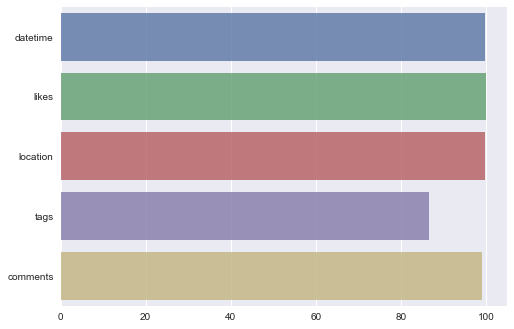

hadonggwang


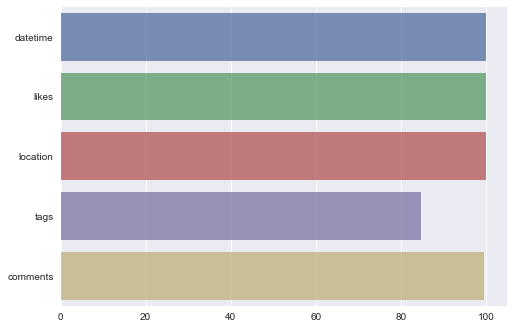

coochullo


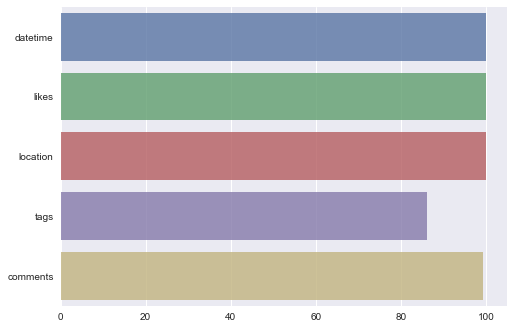

In [6]:
for key in data_dic.keys():
    print(key)
    df_temp = (data_dic[key].count()*100./data_dic[key].count().max()).to_frame()
    df_temp = (df_temp).stack().unstack(0)
    sns.barplot(data=df_temp, orient='h', alpha=0.8)
    plt.show()
plt.close()

### Changing timezone from Utc to Seoul(local timezone)

In [68]:
for key in data_dic.keys():
    df1 = data_dic[key]
    df1.datetime = pd.to_datetime(df1.datetime)
    df1 = df1.set_index('datetime').tz_convert(seoultz, level=0).tz_convert(None)
    df1 = df1.reset_index()
    data_dic[key] = df1

### Add columns: week(weekday) and hour(24h)

In [ ]:
for key in data_dic.keys():
    data_dic[key]['week'] = data_dic[key].datetime.dt.dayofweek #0:Mon ... 6: Sun
    data_dic[key]['hour'] = data_dic[key].datetime.dt.hour

### Add location

In [81]:
df0 = data_dic[data_dic.keys()[0]]
df0['location'] = np.full_like(df0['datetime'].astype(str), data_dic.keys()[0])
for key in data_dic.keys():
    if key == data_dic.keys()[0]:
        pass
    else:
        df1 = data_dic[key]
        df1['location'] = np.full_like(df1.datetime.astype(str), key)
    df0 = pd.concat([df0, df1])

### Save dataframe to .csv file

In [85]:
df0.to_csv('insta_final.csv', sep=',')

### Read csv file

In [86]:
df0 = pd.read_csv('insta_final.csv')
df0.drop('Unnamed: 0', axis=1, inplace=True) # Drop unnecessary column
df0.head()

,Unnamed: 0,datetime,likes,location,tags,comments,week,hour
0,0,2016-07-07 19:12:45,88,shindle,#찬이맛집,<user1>$부추밑에 깔려있는 두루치기. 제육볶음 아님. 주물럭아님. #찬이맛집,3.0,19.0
1,1,2017-02-18 14:38:16,38,shindle,#수요미식회#제육볶음,<user1>$전래 맛있 제육쓰 #수요미식회#제육볶음<user2>$차암나..그록케 ...,5.0,14.0
2,2,2016-10-03 22:10:32,61,shindle,#수요미식회맛집#제육볶음#신들래보쌈#냄비밥#먹스타그램,<user1>$냄비밥에 자작한 제육볶음 올려서#수요미식회맛집 #제육볶음#신들래보쌈 ...,0.0,22.0
3,3,2017-02-27 03:19:29,46,shindle,#월욜미식회#신들래보쌈,<user1>$일하기전 반주 🎹 #월욜미식회 #신들래보쌈<user2>$나도<use...,0.0,3.0
4,4,2017-04-07 03:04:55,43,shindle,#제육볶음#수요미식회#신들레보쌈#숙대입구#남영역,<user1>$#제육볶음 #수요미식회 #신들레보쌈 #숙대입구 #남영역_들기름맛이 잘...,4.0,3.0
